### 0.导入函数库

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from utilities.focal_mechanisms import (
    FocalMechanism, NodalPlane, Polarity)
import matplotlib.pyplot as plt
from utilities.focal_mechanisms import FocalMechanism, NodalPlane, Polarity 
import ipysheet
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

### 1.震源实验一

移动走向、倾角和滑移角的滑块，与第一个节点面正交，且第一个节点面的滑移矢量与第二个节点面的极点对齐

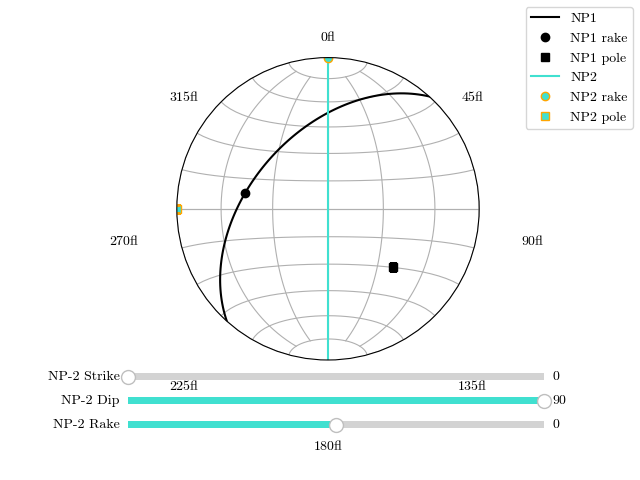

In [2]:

first_nodal_plane = NodalPlane(
    strike=222,
    dip=48, 
    rake=112
)
fig = FocalMechanism(nodal_plane_1=first_nodal_plane).tweak_np2(show=False)

### 2.震源实验二

编辑台站极性（U：表示压缩，D：表示膨胀）

In [3]:
datatable = ipysheet.sheet(rows=19, columns=4)
header = ipysheet.row(
    0, ["Station", "Azimuth", "Take-off angle", "Polarity (U/D)"],
    background_color="lightgrey")
cells = ipysheet.cell_range(
    [["T01", 312, 27, "U"], 
     ["T02", 318, 21, "U"],
     ["T03", 174, 27, "D"],
     ["T04", 11, 70, "D"],
     ["T05", 176, 71, "D"],
     ["T06", 82, 40, "U"],
     ["T07", 245, 41, "U"],
     ["T08", 278, 31, "U"],
     ["T09", 316, 30, "U"],
     ["T10", 75, 34, "U"],
     ["T11", 267, 30, "U"],
     ["T12", 16, 50, "D"],
     ["T13", 40, 52, "D"],
     ["T14", 297, 33, None],
     ["T15", 132, 22, None],
     ["T16", 10, 35, None],
     ["T17", 123, 36, None],
     ["T18", 36, 30, None]
    ], row_start=1);

datatable

Sheet(cells=(Cell(column_end=3, column_start=0, row_end=0, row_start=0, squeeze_column=False, style={'backgrou…

将两个节点面与极性拟合，且正交

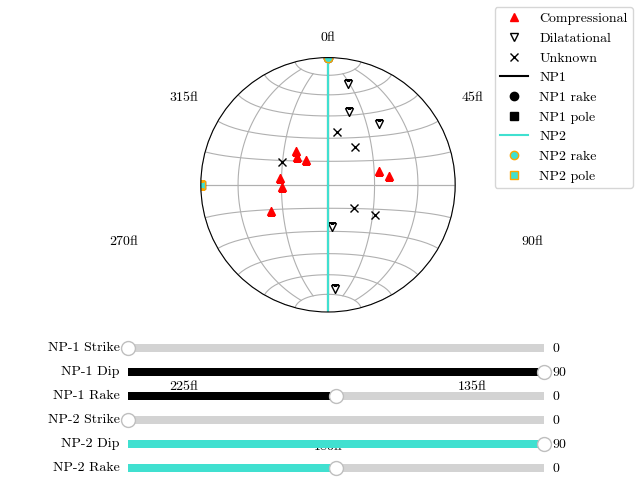

In [4]:
polarities = [Polarity(azimuth=v[1], toa=v[2], polarity=v[3]) for v in cells.value]
fig = FocalMechanism(polarities=polarities).find_planes()

### 3.从IRIS获得合成地震数据

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from obspy.clients.syngine import Client

c = Client()
bulk = [
    {"latitude": 47.0, "longitude": 12.1, "depth": 1000, 
     "networkcode": "AA", "stationcode": "BB", "locationcode": "CC"}
]

st = c.get_waveforms_bulk(
    model="iasp91_2s", bulk=bulk, sourcelatitude=12.3,
    sourcelongitude=75.3, sourcedepthinmeters=54321,
    sourcemomenttensor=[1E19, 1E19, 1E19, 0, 0, 0],
    components="Z")
print(st.sort())  

_ = st.plot()

print(c.get_available_models())

ImportError: cannot import name 'get_available_models' from 'obspy.clients.syngine.client' (/home/muly/.local/lib/python3.11/site-packages/obspy/clients/syngine/client.py)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


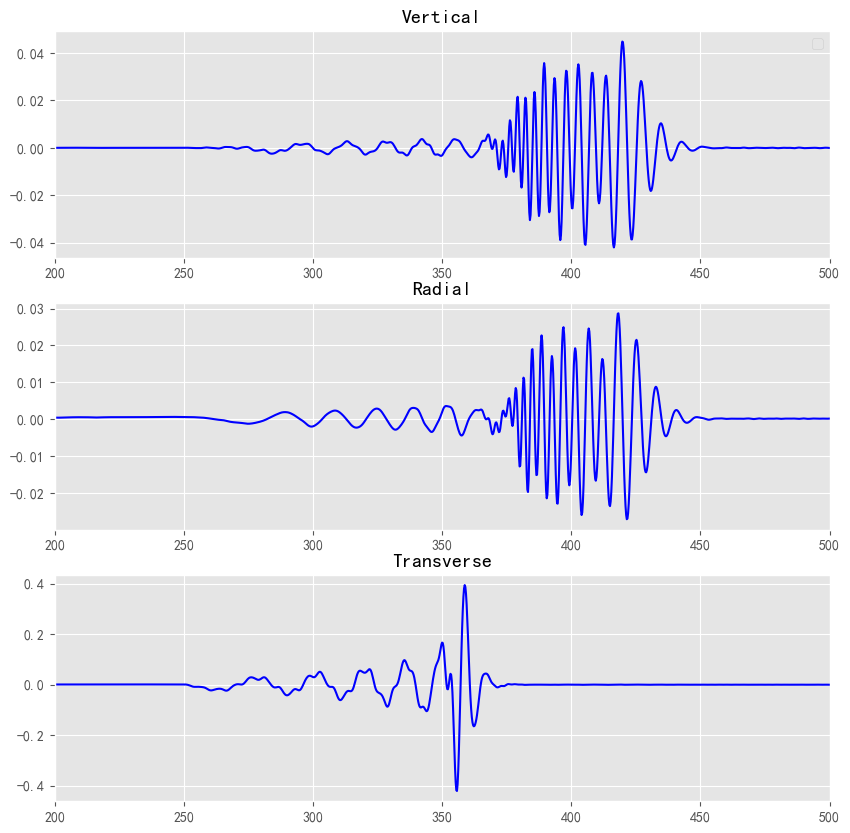

In [8]:
import obspy
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from obspy.clients.syngine import Client

# 使用ak135f_5s模型
BASE_URL = "http://service.iris.edu/irisws/syngine/1/query?format=miniseed&model=ak135f_5s&"

# 获取震源深度为1公里，震中距为10度时的分量
GREENS_URL = BASE_URL + \
    "greensfunction=1&sourcedistanceindegrees=10&sourcedepthinmeters=1000"

st = obspy.read(GREENS_URL)

# 矩张量示例
m_rr, m_tt, m_pp, m_rt, m_rp, m_tp = 1E20, -2E20, 0.4E20, -0.7E20, 1.3E20, -2E20

MT_URL = BASE_URL + (
    "sourcelatitude=0&sourcelongitude=10&sourcedepthinmeters=1000&"
    "sourcemomenttensor=%g,%g,%g,%g,%g,%g&"
    "receiverlatitude=0&receiverlongitude=0&"
    "components=ZRT"% (m_rr, m_tt, m_pp, m_rt, m_rp, m_tp))
st_mt = obspy.read(MT_URL.replace("+", ""))

# Compare everything.
plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.title("Vertical")
tr_mt = st_mt.select(component="Z")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="b")
plt.xlim(200, 500)

plt.subplot(312)
plt.title("Radial")
tr_mt = st_mt.select(component="R")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="b")
plt.xlim(200, 500)

plt.subplot(313)
plt.title("Transverse")
tr_mt = st_mt.select(component="T")[0]
plt.plot(tr_mt.times(), tr_mt.data, color="b")
plt.xlim(200, 500)

plt.show()